In [9]:
from torch import nn
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from transformers import SegformerForSemanticSegmentation
from transformers import TrainingArguments
# from createDataset import dataset
from torchvision.transforms import ColorJitter
from transformers import SegformerImageProcessor
from transformers import TrainingArguments
import torch
from torch import nn
import evaluate
from transformers import Trainer
import matplotlib.pyplot as plt
import matplotlib.image as pltimage
import cv2
from Segmentation_model import UnetModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model_path = 'model_ckpt/unet_model/unet_ep100_bcelosswithweight_onehot_2210.ckpt'
model = UnetModel.load_from_checkpoint(model_path, torch.device('cpu'))
model.eval()

cuda:0


UnetModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batch

In [10]:
def processImage_unet(image_path):
    image_test = cv2.imread(image_path)
    image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
    image_test = image_test.transpose(2,0,1)
    image_test = np.expand_dims(image_test, axis=0)
    image_test = torch.from_numpy(image_test)
    return(image_test)

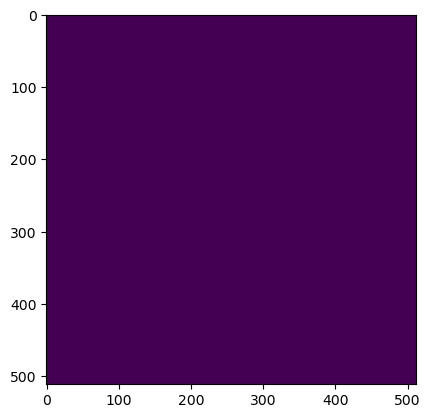

In [12]:
image_path = 'data/test_image_512/image_249.jpg'
x = processImage_unet(image_path)
y_logit = model(x)
y = y_logit.argmax(axis = 1)
y = np.array(y)
plt.imshow(y[0])

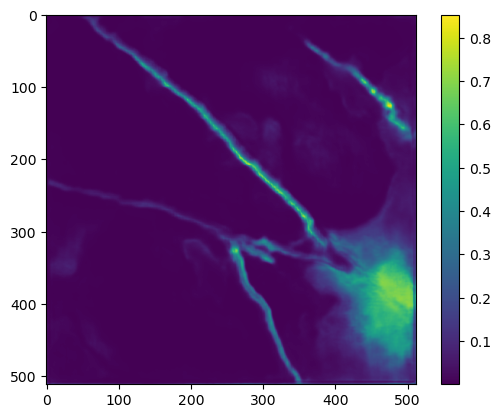

In [13]:
p = torch.nn.functional.softmax(y_logit, dim=1)
p_array = p.detach().numpy()
def calculate_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1) 

entropy_map = calculate_entropy(p_array)
plt.imshow(entropy_map[0])
plt.colorbar()
plt.show()

In [5]:
def mIOU(prediction, label, num_classes):
    # prediction= prediction.max(1)[1].float().cpu().numpy()
    # label = label.float().cpu().numpy() 
    
    iou_list = list()
    present_iou_list = list()
    # all_iou_list = list()

    for sem_class in range(num_classes):
        # print(sem_class)
        pred_inds = (prediction == sem_class)
        target_inds = (label == sem_class)
        if target_inds.sum().item() == 0:
            iou_now = float('nan')
            # iou_now = 0
            # all_iou_list
        else:
            # print(sem_class)
            intersection_now = (pred_inds[target_inds]).sum().item()
            union_now = pred_inds.sum().item() + target_inds.sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    miou = np.mean(present_iou_list)
    return miou, iou_list

In [7]:
from PIL import Image
m_accuracy=list()
mean_IOU = list()
perClass_IOU = np.arange(8)
test_size = 945
# 1021 for test set, 5103 for whole
for i in range(test_size): 
    # image = test_ds[i]['pixel_values']
    # gt_seg = test_ds[i]['labels']
    # image_path = 'data/test_image_512/' + f'image_{i}.jpg'
    image = Image.open('data/test_image_512/' + f'image_{i}.jpg')
    gt_seg = Image.open('data/test_annotation_512/' + f'annotation_{i}.png')
    inputs = processImage_unet('data/test_image_512/' + f'image_{i}.jpg')
    outputs = model(inputs)
    logits = outputs  # shape (batch_size, num_labels, height/4, width/4)
    # First, rescale logits to original image size
    upsampled_logits = logits
    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]
    pred_arr = np.array(pred_seg)
    gt_arr = np.array(gt_seg)
    acc = np.mean((pred_arr == gt_arr))
    m_accuracy.append(acc)
    m_iou,iou_list = mIOU(pred_arr,gt_arr,8)
    iou_arr = np.array(iou_list)
    mean_IOU.append(m_iou)
    # print(type(perClass_IOU))
    perClass_IOU = np.vstack([perClass_IOU,iou_arr])
# Print results
print("Overall mean IOU:",np.mean(mean_IOU))
print("Overall mean Acc:",np.mean(m_accuracy))
perClass_IOU = perClass_IOU[1:]
print("Per class IOU:", np.nanmean(perClass_IOU,axis = 0))

Overall mean IOU: 0.6490141168625577
Overall mean Acc: 0.9029220459953187
Per class IOU: [0.9169984  0.15516816 0.43143705 0.03685346 0.53101663 0.28672646
        nan        nan]


/tmp/ipykernel_254656/2820425741.py:33: RuntimeWarning: Mean of empty slice
  print("Per class IOU:", np.nanmean(perClass_IOU,axis = 0))


In [15]:
from PIL import Image
import rasterio

allresult = np.zeros((1, 7091,48436))
width = 512
height = 512
num_image = 1485 # 1485  # 392 # 96
col_num = 48436 //(width-20) +1
row_num = 7091//(height-20) +1
horz_flip = False

# p = torch.nn.functional.softmax(upsampled_logits, dim=1)
# p_array = p.detach().numpy()
def calculate_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1) 

get_uncertainty = False
get_probabilityperclass = True
get_predictmap = False
for i in range(num_image):
    # image = test_ds_orig[n]['pixel_values']
    # gt_seg = test_ds_orig[n]['labels']
    # image = Image.open('data/temporal_compare_data/201113_image_512_overlap_20/' + f'image_{i}.jpg')
    # gt_seg = Image.open('data/annotation_overlap/' + f'annotation_{i}.png')
    # if horz_flip:
    #     horz_flip_img = image.transpose(method=Image.FLIP_LEFT_RIGHT)
    #     image = horz_flip_img
    inputs = processImage_unet('data/temporal_compare_data/201113_image_512_overlap_20/' + f'image_{i}.jpg')
    outputs = model(inputs)
    logits = outputs # shape (batch_size, num_labels, height/4, width/4)
    # print(logits.shape)
    # First, rescale logits to original image size
    upsampled_logits = logits
    probability = nn.functional.softmax(upsampled_logits, dim = 1)
    p_array = probability.detach().numpy()
    if get_probabilityperclass:
        pred_arr = p_array[0]
    if get_uncertainty:        
        entropy_map = calculate_entropy(p_array)
        pred_arr = entropy_map[0]
    if get_predictmap:
        pred_seg = upsampled_logits.argmax(dim=1)[0]
        pred_arr = np.array(pred_seg)

    # probability_singlelayer = probability[0,5]
    # Second, apply argmax on the class dimension
    # pred_seg = upsampled_logits.argmax(dim=1)[0]
    # pred_arr = pred_seg.detach().numpy()  
    # if horz_flip:
    #     horz_flip_img = pred_arr[:,::-1]
    #     pred_arr = horz_flip_img
    row_idx = i//col_num
    col_idx = i%col_num
    # print("Current pred unique and shape: ",np.unique(pred_arr))
    # print(row_idx, col_idx,pred_arr.shape)
    if col_idx<(col_num-1):
        col = col_idx*(width-20)          
    elif col_idx==(col_num-1):
        col = 48436 - width                 
    if row_idx<(row_num-1):
        row = row_idx*(height-20)
    elif row_idx==(row_num-1):
        row = 7091 - height
    if col_idx == 0 or col_idx ==(col_num-1) or row_idx ==0 or row_idx ==(row_num-1):
        allresult[:,int(row):int(row)+height, int(col):int(col)+width] = pred_arr[1]
    else:
        allresult[:,int(row)+10:int(row)+height-10, int(col) +10:int(col)+width-10] = pred_arr[1,10:-10,10:-10]

if get_uncertainty or get_probabilityperclass:
    allresult = allresult*100

with rasterio.open("data/refined/RadiusCropped.tif") as radiusimg:
    profile = radiusimg.profile

with rasterio.open(f'data/result/201113_unet_ep100_bcelosswithweight_2210_onehot_512_512_tectonicfault.tif', 'w', **profile) as dst:
    dst.write(allresult[0].astype(rasterio.uint8), 1)

In [29]:
with rasterio.open(f'data/result/201113_unet_ep500_1810_onehot_512_512_uncertainty.tif', 'w', **profile) as dst:
    dst.write(allresult[0].astype(rasterio.uint8), 1)

In [ ]:
# Load groundtruth of 201113, and compare with the prediction
import rasterio 
from rasterio.windows import Window
import numpy as np
from sklearn.metrics import confusion_matrix

groundtruth_path = "data/temporal_compare_data/201113_label/201113_label.tif"
pred_result_path = "data/result/201113_unet_ep500_1810_onehot_512_512.tif"

classes = np.arange(6)
cm = np.zeros((6,6))
for i in range(5):
    # print(i)
    window = Window(i*10000, 0, 10000,7091)
    with rasterio.open(groundtruth_path) as gtimg:
        groundtruth = gtimg.read(window = window)
        # print(groundtruth.shape)
    # Load groundtruth of 201113, and compare with the prediction
    with rasterio.open(pred_result_path) as predimg:
        prediction = predimg.read(window = window)
        # print(prediction.shape)
    ground_truth = groundtruth.flatten()
    predictions = prediction.flatten()  
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(ground_truth, predictions, labels=classes)
    # print(conf_matrix)
    cm = cm+conf_matrix
    # print(conf_matrix)
print("Done calculate confusion matrix!")

# Calculate Overall Accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f'Overall Accuracy: {accuracy:.4f}')

# Calculate Intersection over Union (IoU) and Per-Class IoU
iou_per_class = []
for i in range(6):
    intersection = cm[i, i]
    union = np.sum(cm[i, :]) + np.sum(cm[:, i]) - intersection
    iou = intersection / union if union != 0 else 0
    iou_per_class.append(iou)
    print(f'IoU for class {classes[i]}: {iou:.4f}')

# Calculate Mean IoU
mean_iou = np.mean(iou_per_class)
print(f'Mean IoU: {mean_iou:.4f}')

In [ ]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix_norm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_norm, annot=True,fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# import rasterio 
# with rasterio.open("data/refined/RadiusCropped.tif") as radiusimg:
#     profile = radiusimg.profile

# with rasterio.open('data/temporal_compare_data/201113_unet_ep500_focalloss_512train_512test.tif', 'w', **profile) as dst:
    # dst.write(allresult[0].astype(rasterio.uint8), 1)